In [154]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
import itertools

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap


#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

wc = WordCloud()

# Data Acquisition

In [25]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)



#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])

df = df.sample(frac = 1)
# dependent and independent variable
X = df['text']
y = df['target']

df['label'].value_counts()
#_____________________________________________________________________________________________________________________________________________

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [56]:
df = df.dropna()

# Exploratory Data Analysis

In [32]:
print(df.shape)
df.head()

(11314, 3)


,text,label,target
768,\nThe oclock widget was written using the SHAP...,computer,1
2662,I have a quick question regarding the Rockwell...,computer,1
7561,\nI have the same problem. I have looked at M...,computer,1
8347,AHL CALDER CUP PLAYOFF GAME(S) PLAYED ON 4/16\...,sport,7
1412,"\nIn the case of victimless crimes yes, I thin...",politics,3


In [3]:
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

### Sample for EDA

In [30]:
df_s = df.sample(500)
df_s['spacy_obj'] = df_s['text'].apply(lambda x:nlp(x))
df_s['label'].value_counts()

In [43]:
sample = df_s.sample(1)
sample

,text,label,target,spacy_obj
10727,I bought the diamond stealth 24 a few months a...,computer,1,"(I, bought, the, diamond, stealth, 24, a, few,..."


In [45]:
print(sample.text.values[0] ,sample.label)

I bought the diamond stealth 24 a few months ago.  it seems to be a
great card especially with my multimedia presentations.  It runs graphics
and animation as well as some near full motion video very well.  The only
thing I can tell that it lacks is speed above 256 colors.  Its qualit in
between 256 and 16.7 million collors un unreal but you definitly
compromise speed.  It seems to be a great card for graphics and it comes
with some great software, but Im not so sure about the excelerator
part.  I used to own a paridise and it doesnt seem to be much faster
than that.  One thing I do like is that it loads its own vesa driver
from ROM at startup, (I think) because I have never had to load it for
links386 or any other programs that require special VESA drivers at
startup. 



gromi a16pd


                                       HINTMATT@BA.BA.ISU.EDU


 10727    computer
Name: label, dtype: object


In [115]:
sample

,text,label,target,spacy_obj
10727,I bought the diamond stealth 24 a few months a...,computer,1,"(I, bought, the, diamond, stealth, 24, a, few,..."


In [124]:
len([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ])

146

In [125]:
len(set([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ]))

101

## Example of Preprocessing

In [89]:
df_s

,text,label,target,spacy_obj,tokens,is_alpha_pure,is_alpha_num,len_text,n_unique_text,richness_text
4652,Here's a list of 800 numbers I have compiled f...,computer,1,"(Here, 's, a, list, of, 800, numbers, I, have,...","[Here, 's, a, list, of, 800, numbers, I, have,...","[Here, a, list, of, numbers, I, have, compiled...","['s, 800, ..., \n, ?, \n\n, 's, ,, ,, n't, \n,...",2861,179,0.062566
3041,"UPI Clarinet has just relayed a ""scoop"" from t...",sport,7,"(UPI, Clarinet, has, just, relayed, a, "", scoo...","[UPI, Clarinet, has, just, relayed, a, "", scoo...","[UPI, Clarinet, has, just, relayed, a, scoop, ...","["", "", \n, (, ?, , ..., ), \n, \n, ., , ,, \...",377,67,0.177719
6029,"\n\nWell, it all depends on the motherboard im...",computer,1,"(\n\n, Well, ,, it, all, depends, on, the, mot...","[\n\n, Well, ,, it, all, depends, on, the, mot...","[Well, it, all, depends, on, the, motherboard,...","[\n\n, ,, ., \n\n, 'm, 1x9, \n, ., , 'm, \n, ...",219,35,0.159817
11185,\nThis should not be the case if they are at a...,automobile,0,"(\n, This, should, not, be, the, case, if, the...","[\n, This, should, not, be, the, case, if, the...","[This, should, not, be, the, case, if, they, a...","[\n, ., \n, \n, ., \n, ., \n, ,, ., \n, (, $, ...",997,177,0.177533
6907,\n\nMore like Philadelphia making dust out of...,sport,7,"( \n\n, More, like, Philadelphia, making, dust...","[ \n\n, More, like, Philadelphia, making, dust...","[More, like, Philadelphia, making, dust, out, ...","[ \n\n, ., \n, ?, \n\n, ., , \n, "", "", \n, .,...",293,49,0.167235
...,...,...,...,...,...,...,...,...,...,...
9161,Osinski):\nyears.\ncity\n\nAre you one of thos...,politics,3,"(Osinski, ):, \n, years, ., \n, city, \n\n, Ar...","[Osinski, ):, \n, years, ., \n, city, \n\n, Ar...","[Osinski, years, city, Are, you, one, of, thos...","[):, \n, ., \n, \n\n, \n, ?, n't, !, \n, ,, .,...",489,84,0.171779
7085,"\n\n\n\nStrictly speaking, you're right - we c...",religion,4,"(\n\n\n\n, Strictly, speaking, ,, you, 're, ri...","[\n\n\n\n, Strictly, speaking, ,, you, 're, ri...","[Strictly, speaking, you, right, we, ca, repen...","[\n\n\n\n, ,, 're, -, n't, _, _, ,, \n, 've, ....",1249,212,0.169736
9905,\nI sometimes wonder if Kekule's dream wasn't ...,medicine,2,"(\n, I, sometimes, wonder, if, Kekule, 's, dre...","[\n, I, sometimes, wonder, if, Kekule, 's, dre...","[I, sometimes, wonder, if, Kekule, dream, was,...","[\n, 's, n't, \n, ;-), ., \n\n]",112,18,0.160714
1129,"\n\nThe next time you go to church, you can ch...",religion,4,"(\n\n, The, next, time, you, go, to, church, ,...","[\n\n, The, next, time, you, go, to, church, ,...","[The, next, time, you, go, to, church, you, ca...","[\n\n, ,, ,, ,, \n, ., , 's, \n, a'soul, ?, \...",1436,241,0.167827


In [66]:
# df_s['tokens'] =
df_s['tokens'] = df_s['spacy_obj'].apply(lambda x:list(x)  )

In [87]:
df_s['is_alpha_pure'].apply(lambda x:len( set(x) ) )

4652     179
3041      67
6029      35
11185    177
6907      49
        ... 
9161      84
7085     212
9905      18
1129     241
7894     448
Name: is_alpha_pure, Length: 500, dtype: int64

In [126]:
df_s['is_alpha_pure'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  token.is_alpha ] )
df_s['is_alpha_num'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  not token.is_alpha ] )
df_s['len_text'] = df_s['text'].apply(lambda x: len(x) )
df_s['unique_text'] = df_s['is_alpha_pure'].apply(lambda x: list(set(x)) ) 
df_s['n_unique_text'] = df_s['is_alpha_pure'].apply(lambda x:len( set(x) ) )
df_s['richness_text'] = df_s['n_unique_text']/df_s['len_text'] 

<AxesSubplot:>

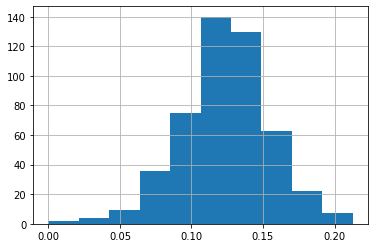

In [127]:
df_s['richness_text'].hist()

In [177]:
from itertools import chain
group_class_docs = df_s.groupby('label')['unique_text'].apply(list) 
group_class_uniqe_texts = group_class_docs.apply(lambda x : list(itertools.chain(*x)))
group_class_uniqe_texts.apply(lambda x:len(x)) 
a = group_class_uniqe_texts.apply(lambda x:str(' '.join(x)))

In [182]:
type(a[0])

str

# Preprocessing Pipeline

In [ ]:
# doc  = nlp('I  @  1223 am happy for your new promotion')
# tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
# filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
# filter_token_sw

In [5]:
# Proportions of labels
pd.DataFrame(y.value_counts()).T

,2,6,3,1,7,0,4,5
target,585,585,585,585,585,585,585,585


### Downsampling Data

In [4]:
def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

df_balanced = downsample(df)
# dependent and independent variable
X = df_balanced['text']
y = df_balanced['target']

In [6]:


    
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)



class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    

    

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 20,dtype=int )

In [7]:
X.shape

(4680,)

# Model Pipeline

### Hyperparameters fine-tuning

In [8]:
# TF IDF DIMENSION will affect the model 
matrix_features  = 2500

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model

#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}


#StratifiedKFold(n_splits=2, shuffle=True)



In [9]:
model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True,max_features=2500)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=skf.split(X,y),
                    param_grid=param_grid,
                    scoring='accuracy')

C:\Users\david\AppData\Local\Temp/ipykernel_12480/1029838963.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


In [10]:
from sklearn import set_config
set_config(display='diagram')

grid

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002AAA2C75660>,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=2500)),
                                       ('sparse_to_dense',
                                        <__main__.DenseTransformer object at 0x000002AAA2C79D60>),
                                       ('scaler', MaxAbsScaler()),
                                       ('kc',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002AAA2C79E50>)]),
             param_grid={'kc__batch_size': [16, 32, 50],
                         'kc__dropout': [0.3, 0.1, 0],
                         'kc__epochs': [20, 30, 50],
                         'kc__neurons': [10, 20, 30, 100],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

#### Grid Search 

In [ ]:
# limit = 100
# X_p = prep_pipeline.fit_transform(X[:limit]).toarray()
# X_p.shape

In [ ]:
# from sklearn.utils.multiclass import type_of_target
# type_of_target(y) , type_of_target(yc)

In [11]:
X_t = prep_pipeline.fit_transform(X)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
results.head()

## Fit the Pipeline

In [ ]:
# TEST SAMPLE
# limit = 1000

# model = create_model(neurons=20)
# model.summary()

In [ ]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X,y)
time.time() - t0 

# Testing Pipeline

In [12]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

In [13]:
X_test_prep = prep_pipeline.transform(X_test)

In [ ]:
y_pred  = opt_pipeline.predict(X_test_prep)
print(classification_report(y_test,y_pred))

In [ ]:
dist_proba_pred = pd.DataFrame(fitted_pipe.predict_proba(X_test_prep), columns=key_categories)

dist_proba_pred.hist(figsize = (10,8));

In [ ]:
df['label'].unique()

In [ ]:
def make_custom_predictions(fitted_pipe = fitted_pipe):return label_encoder.inverse_transform(fitted_pipe.predict(pd.Series(input('Input-Text:'))))

In [ ]:
make_custom_predictions()

In [ ]:
fitted_pipe.named_steps['kc']

In [ ]:
def save_keras_pipe(pipeline):
    # Save the Keras model first:
    pipeline.named_steps['kc'].model.save('keras_model.h5')

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kc'].model = None

    # Finally, save the pipeline:
    joblib.dump(pipeline, 'sklearn_pipeline.pkl')

In [ ]:
save_keras_pipe(fitted_pipe)

In [15]:
from keras.models import load_model
import joblib
# Load the pipeline first:
pipeline = joblib.load('sklearn_pipeline.pkl')

# Then, load the Keras model:
pipeline.named_steps['kc'].model = load_model('keras_model.h5')


              precision    recall  f1-score   support

       sport       0.66      0.67      0.67       794
    computer       0.85      0.71      0.78      1955
       sales       0.58      0.63      0.61       396
    politics       0.73      0.63      0.68      1050
     science       0.69      0.71      0.70       649
  automobile       0.42      0.78      0.55       390
    medicine       0.66      0.53      0.59      1183
    religion       0.62      0.86      0.72       796

    accuracy                           0.68      7213
   macro avg       0.65      0.69      0.66      7213
weighted avg       0.70      0.68      0.68      7213

Normalized confusion matrix


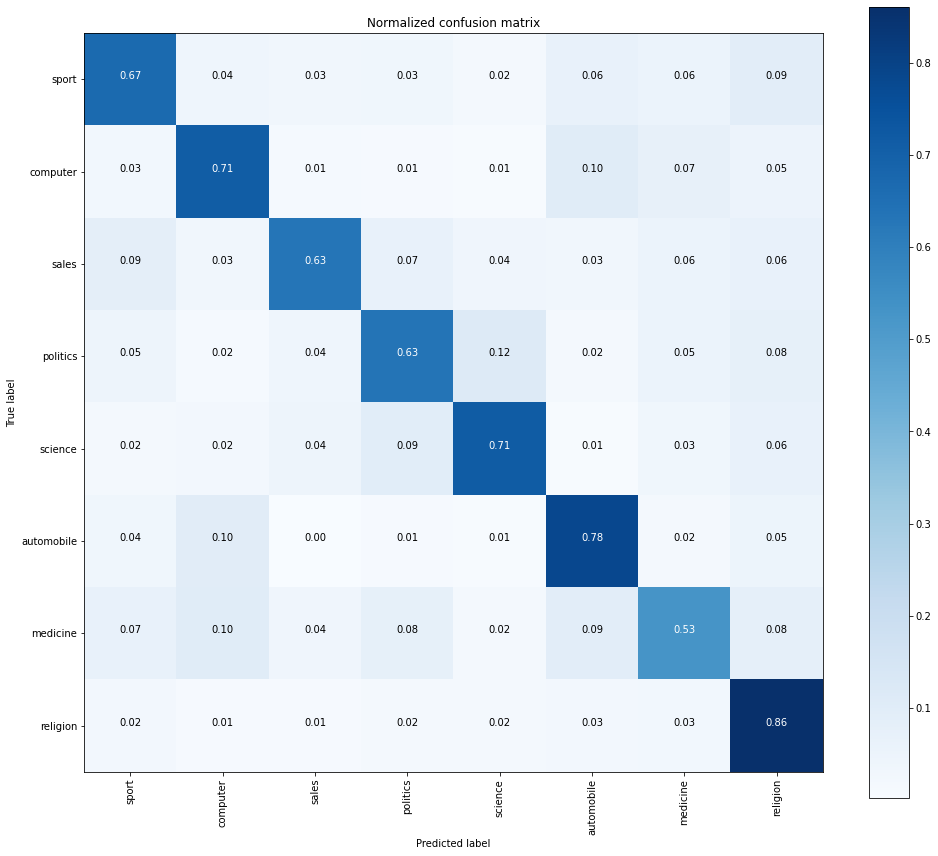

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_pred  = pipeline.predict(X_test_prep)
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

label_names = df['label'].unique()

print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
make_custom_predictions(pipeline)

# Embedding model with Universal Sentence Encoder

In [ ]:
# Inserire flag di dominio dummy 

# def spacy_tokenizer(document, nlp=nlp):
#     # tokenize the document with spaCY
#     doc = nlp(document)
#     # Remove stop words and punctuation symbols
#     tokens = [
#         token.text for token in doc if (
#         token.is_stop == False and \
#         token.is_punct == False and \
#         token.text.strip() != '' and \
#         token.text.find("\n") == -1)]
#     return tokens

import tensorflow_hub as hub
# load embeddings model from Tensorflow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


matrix_features  = 512

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model


In [ ]:
# embed(pd.Series(spacy_preprocessing(X)))

In [ ]:
X_t = prep_pipeline.fit_transform(X)

In [ ]:
class Embedding(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return embed(X).numpy()
    

emb_pipeline = Pipeline([
                    ('embed', Embedding()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])
fitted_pipe_emb = emb_pipeline.fit(X_t,y)

In [ ]:
X_test_prep = prep_pipeline.transform(X_test)

In [ ]:
y_pred  = fitted_pipe_emb.predict(X_test_prep)
print(classification_report(y_test,y_pred))